# The Earth Impact Database

The [Earth Impact Database](http://www.passc.net/EarthImpactDatabase/New%20website_05-2018/Index.html) is a collection of images, publications and abstracts that provides information about confirmed impact structures for the scientific community. It is hosted at the [Planetary and Space Science Centre (PASSC)](http://www.passc.net/AboutUs/index.html) of the [University of New Brunswick](https://www.unb.ca/).

![Meteor crater, AZ, USA](files/meteorcrater_aer_2007158.jpg)
A NASA image of Meteor Crater (Barringer Crater) in Arizona, USA

The goal of this notebook will be to extract data from the EID and analyse and display it using pandas and geopandas.

The EID website isn't perfect, but the data is presented in reasonably-well formatted HTML tables (one per continent, on different pages) which can be scraped by `pandas.read_html`. First of all, let's grab local copies of these HTML pages so we don't have to keep hitting the EID server. We'll put them in a directory `html`:



In [6]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas

# The directory we're going to save local copies of the HTML files into.
HTML_DIR = 'html'
if not os.path.exists(HTML_DIR):
    os.mkdir(HTML_DIR)

# The URLs for the HTML files at the online Earth Impact Database (EID).
BASE_URL = 'http://www.passc.net/EarthImpactDatabase/New%20website_05-2018/'
urls = {'North America': BASE_URL + 'NorthAmerica.html',
        'South America': BASE_URL + 'SouthAmerica.html',
        'Europe': BASE_URL + 'Europe.html',
        'Asia': BASE_URL + 'AsiaRussia.html',
        'Africa': BASE_URL + 'Africa.html',
        'Australia': BASE_URL + 'Australia.html'
       }
# Make a dictionary of local filenames (without path). Use the same filename as
# on the EID server.
filenames = dict((continent,
                  url.rsplit('/', 1)[-1]) for continent ,url in urls.items())

def get_htmlpath(filename):
    """Get qualified path to local HTML file filename."""
    return os.path.join(HTML_DIR, filename)

def fetch_html(continent, filename):
    """Fetch HTML file for continent from internet and save as filename."""

    print('Fetching HTML file', filename)
    url = urls[continent]
    req = urllib.request.urlopen(url)
    html = req.read().decode()
    with open(get_htmlpath(filename), 'w') as fo:
        fo.write(html)

# Fetch the HTML into local files if we don't have them already.
for continent, filename in filenames.items():
    if not os.path.exists(get_htmlpath(filename)):
        fetch_html(continent, filename)


Fetching HTML file NorthAmerica.html
Fetching HTML file SouthAmerica.html
Fetching HTML file Europe.html
Fetching HTML file AsiaRussia.html
Fetching HTML file Africa.html
Fetching HTML file Australia.html


In [8]:
!ls html

Africa.html       Australia.html    NorthAmerica.html
AsiaRussia.html   Europe.html       SouthAmerica.html


The data tables are nested in an annoying way, so it's the second one that will contain our data: `pd.read_html(filepath)[1]`. We can first write some custom parsing functions to deal with latitudes and longitudes (conversion to a signed decimal value), various footnote annotations (`*`), missing data, and (particularly for the age column) an uncertainty or bound to the value (e.g. `254.7 ± 2.5`, `< 70`).

In [23]:
def parse_latlong(s):
    """Parse an angle in degrees and minutes into a decimal float."""

    s = s.replace('N','').replace('S','-').replace('W','-').replace('E','')
    s = s.replace(' ','').replace("'",'')
    d, m = s.split('°')
    return float(d) + float(m)/60

def parse_numeric(s):
    """Parse s into a float if possible, ignoring asterisks."""

    s = s.replace('*', '')
    return pd.to_numeric(s, errors='coerce')

def parse_age(s):
    """Parse s into a crater age if possible, handling uncertainties."""

    note = ''
    s = s.replace('*', '')

    if '<' in s:
        note = 'upper bound'
    elif '>' in s:
        note = 'lower bound'
    elif '~' in s:
        note = 'approximate age'
    s = s.replace('<', '').replace('>', '').replace('~', '')
    if '±' in s:
        age, unc = s.split('±')
        return float(age), float(unc), note
    elif '-' in s:
        lower_age, upper_age = s.split('-')
        try:
            lower_age, upper_age = float(lower_age), float(upper_age)
        except ValueError:
            return np.nan, np.nan, 'parsing age failed'
        mean_age = (lower_age + upper_age) / 2
        unc = mean_age - lower_age
        return mean_age, unc, note

    try:
        return float(s), np.nan, note
    except ValueError:
        return np.nan, np.nan, 'parsing age failed'

In [26]:
def read_html_to_pd(filename):
    filepath = get_htmlpath(filename)
    # It's the second table we want.
    df = pd.read_html(filepath)[1]

    # The column names have been put in the first row: fix this.
    df.columns = df.iloc[0]
    df = df.reindex(df.index.drop(0))

    # Convert longitude and latitude strings to floats
    df['Longitude'] = df['Longitude'].apply(parse_latlong)
    df['Latitude'] = df['Latitude'].apply(parse_latlong)
    df['Diameter (km)'] = df['Diameter (km)'].apply(parse_numeric)
    df['Age (Ma)*'], df['Age unc. (Ma)'], df['Note'] = zip(
                                *df['Age (Ma)*'].apply(parse_age))
    df['Exposed'] = df['Exposed'] == 'Y'
    df['Drilled'] = df['Drilled'] == 'Y'
    return df

dd = {}
# Parse the HTML tables for the data, for each continent
for continent, filename in filenames.items():
    dd[continent] = read_html_to_pd(filename)
df = pd.concat(dd)

We might find it useful to have a small function to summarize a crater from the DataFrame:

In [43]:
def crater_summary(crater):
    """Return a string summarizing the important features of crater."""
    
    return (f"{crater['Crater Name']} "
            f"({crater['Latitude']:.1f}, {crater['Longitude']:.1f})"
            f", {crater['Diameter (km)']} km, {crater['Age (Ma)*']} Ma")

In [44]:
i_oldest = df['Age (Ma)*'].idxmax()
print('Oldest crater:', crater_summary(df.loc[i_oldest]))

Oldest crater: Suavjärvi (63.1, 33.4), 16.0 km, 2400.0 Ma


The largest impact craters, by continent:

In [52]:
max_idx = df.groupby(level=0)['Diameter (km)'].idxmax()
df.loc[max_idx]

,,Crater Name,Location,Latitude,Longitude,Diameter (km),Age (Ma)*,Exposed,Drilled,Target Rock**,Bolide Type***,Age unc. (Ma),Note
Africa,20,Vredefort,South Africa,-27.000000,27.500000,160.0,2023.00,True,True,M,Chondrite,4.00,
Asia,20,Popigai,Russia,71.650000,111.183333,90.0,35.70,True,True,M,Chondrite,0.20,
Australia,1,Acraman,South Australia,-31.983333,135.450000,90.0,590.00,True,False,C,Chondrite,NaN,approximate age
Europe,32,Siljan,Sweden,61.033333,14.866667,52.0,376.80,True,True,M,-,1.70,
North America,10,Chicxulub,"Yucatan, Mexico",21.333333,-88.500000,150.0,64.98,False,True,M,Chondrite,0.05,
South America,1,Araguainha,Brazil,-15.216667,-51.016667,40.0,254.70,True,False,M,-,2.50,


Finally, let's use geopandas to plot the crater locations as circles with areas in proportion to their size:

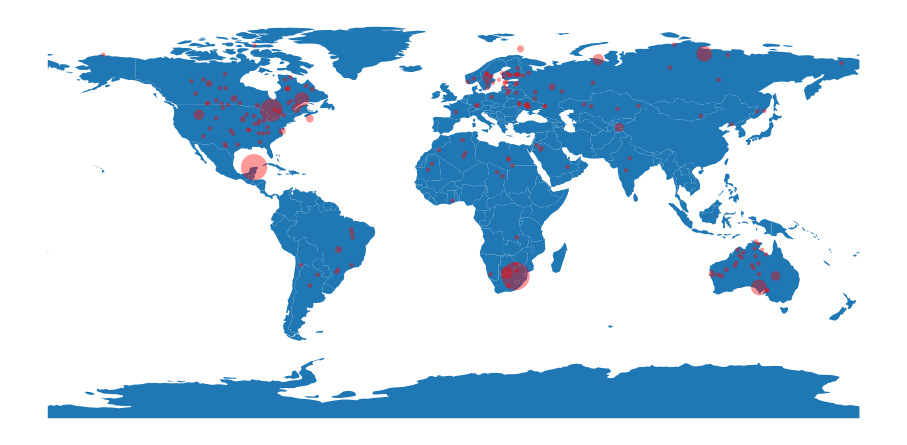

In [46]:
plt.rcParams['figure.figsize'] = [16, 9]
fig, ax = plt.subplots()
ax.set_aspect('equal')

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax)
sizes = np.clip((np.pi*df['Diameter (km)']/2)**2 / 80, 20, None)
ax.scatter(df['Longitude'], df['Latitude'], c='r', alpha=0.4, s=sizes,
           edgecolor='none')
_ = ax.axis('off')